In [ ]:
# default_exp modeling.question_answering

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import os, ast, inspect

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, CategoryBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
# from fastai.metrics import perplexity
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from seqeval import metrics as seq_metrics
from transformers import AutoModelForQuestionAnswering, logging

from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock, BlurrDataLoader, first_blurr_tfm
from blurr.modeling.core import HF_BaseModelCallback, HF_PreCalculatedLoss, Blearner
from blurr.data.question_answering import HF_QuestionAnswerInput, HF_QABeforeBatchTransform

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc
from transformers import AutoConfig

from blurr.utils import print_versions
from blurr.modeling.core import HF_BaseModelWrapper, HF_PreCalculatedLoss, hf_splitter
from blurr.data.question_answering import pre_process_squad

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print_versions('torch fastai transformers')

torch: 1.7.1
fastai: 2.5.0
transformers: 4.9.2


In [ ]:
#hide_input
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
# full
# squad_df = pd.read_csv('./data/task-question-answering/squad_cleaned.csv'); len(squad_df)

# sample
squad_df = pd.read_csv('./squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start': [269]}",train,in the late 1990s,False
1,56be85543aeaaa14008c9065,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",What areas did Beyonce compete in when she was growing up?,"{'text': ['singing and dancing'], 'answer_start': [207]}",train,singing and dancing,False


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_model_cls = AutoModelForQuestionAnswering

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=hf_model_cls)

# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
#                                                                   model_cls=AutoModelForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name,
#                                                                   model_cls=AutoModelForQuestionAnswering)

In [ ]:
squad_df = squad_df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), axis=1)

In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
214,56be97c73aeaaa14008c912a,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Beyonce would take a break from music in which year?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], beyonce, would, take, a, break, from, music, in, which, year, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, ballet...",99,23,24
215,56be97c73aeaaa14008c912b,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Which year did Beyonce and her father part business ways?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], which, year, did, beyonce, and, her, father, part, business, ways, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, b...",99,23,24


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'

before_batch_tfm = HF_QABeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                             max_length=max_seq_len, 
                                             truncation=trunc_strat, 
                                             tok_kwargs={ 'return_special_tokens_mask': True })

blocks = (
    HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_QuestionAnswerInput), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 1

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,start/end,answer
0,"what other language has she sung? beyonce's music is generally r & b, but she also incorporates pop, soul and funk into her songs. 4 demonstrated beyonce's exploration of 90s - style r & b, as well as further use of soul and hip hop than compared to previous releases. while she almost exclusively releases english songs, beyonce recorded several spanish songs for irreemplazable ( re - recordings of songs from b'day for a spanish - language audience ), and the re - release of b'day. to record these, beyonce was coached phonetically by american record producer rudy perez.","(73, 74)",spanish
1,"how many miles was the village frederic born in located to the west of warsaw? fryderyk chopin was born in zelazowa wola, 46 kilometres ( 29 miles ) west of warsaw, in what was then the duchy of warsaw, a polish state established by napoleon. the parish baptismal record gives his birthday as 22 february 1810, and cites his given names in the latin form fridericus franciscus ( in polish, he was fryderyk franciszek ). however, the composer and his family used the birthdate 1 march, [ n 2 ] which is now generally accepted as the correct date.","(35, 36)",29


### Training

Here we create a question/answer specific subclass of `HF_BaseModelCallback` in order to get all the start and end prediction.  We also add here a new loss function that can handle multiple targets

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """The prediction is a combination start/end logits"""
    def after_pred(self):
        super().after_pred()
        self.learn.pred = (self.pred.start_logits, self.pred.end_logits)

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(
        self, 
        loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], 
        loss_classes_kwargs=[{}, {}], 
        weights=[1, 1], 
        reduction='mean'
    ):
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self=self, names='loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
#hide_output
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 127 x 1024      
Embedding                                 31254528   False     
Embedding                                 524288     False     
Embedding                                 2048       False     
LayerNorm                                 2048       True      
Dropout                                                        
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Dropout                                                        
Linear                                    1049600    False     
LayerNorm                                 2048       True      
Dropout                                                        
____________________________________________________________________________
            

In [ ]:
print(len(learn.opt.param_groups))

3


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 127]))

/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.0033113110810518267, steep=0.0014454397605732083, valley=0.0008317637839354575, slide=3.630780702224001e-05)

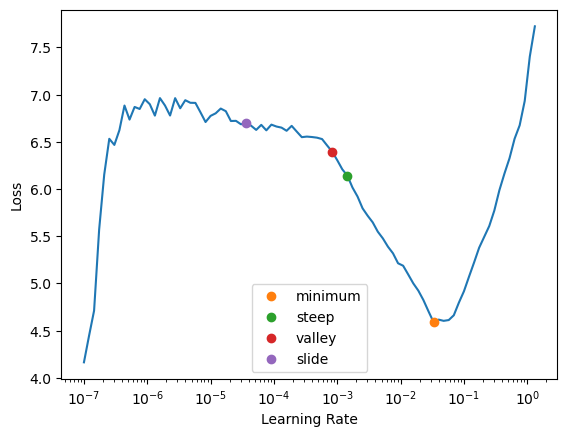

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.298746,1.505928,00:04
1,2.464368,0.875427,00:04
2,1.702078,0.798447,00:04


### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
#export
@typedispatch
def show_results(
    x:HF_QuestionAnswerInput, 
    y, 
    samples, 
    outs, 
    learner, 
    skip_special_tokens=True, 
    ctxs=None, 
    max_n=6, 
    trunc_at=None, 
    **kwargs
):     
    tfm = first_blurr_tfm(learner.dls)
    hf_tokenizer = tfm.hf_tokenizer
    
    res = L()
    for sample, input_ids, start, end, pred in zip(samples, x, *y, outs):
        txt = hf_tokenizer.decode(sample[0], skip_special_tokens=True)[:trunc_at]
        ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[start:end]
        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[int(pred[0]):int(pred[1])]
        
        res.append((txt,
                    (start.item(),end.item()), hf_tokenizer.convert_tokens_to_string(ans_toks),
                    (int(pred[0]),int(pred[1])), hf_tokenizer.convert_tokens_to_string(pred_ans_toks)))

    df = pd.DataFrame(res, columns=['text', 'start/end', 'answer', 'pred start/end', 'pred answer'])
    display_df(df[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, skip_special_tokens=True, max_n=2, trunc_at=500)

,text,start/end,answer,pred start/end,pred answer
0,"how many people lost their jobs over beyonce backing out of the deal? the release of a video - game starpower : beyonce was cancelled after beyonce pulled out of a $ 100 million with gatefive who alleged the cancellation meant the sacking of 70 staff and millions of pounds lost in development. it was settled out of court by her lawyers in june 2013 who said that they had cancelled because gatefive had lost its financial backers. beyonce also has had deals with american express, nintendo ds and l","(51, 52)",70,"(51, 52)",70
1,"which famous landmark did beyonce see in china? beyonce announced a hiatus from her music career in january 2010, heeding her mother's advice, "" to live life, to be inspired by things again "". during the break she and her father parted ways as business partners. beyonce's musical break lasted nine months and saw her visit multiple european cities, the great wall of china, the egyptian pyramids, australia, english music festivals and various museums and ballet performances.","(73, 78)",the great wall of china,"(73, 78)",the great wall of china


... and lets see how `Learner.blurr_predict` works with question/answering tasks

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.blurr_predict(inf_df.iloc[0])

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([2.3153e-07, 8.2441e-08, 3.7619e-09, 9.6320e-09, 6.6307e-09, 3.9657e-09,
        6.0989e-10, 2.3153e-07, 6.8276e-04, 4.3125e-05, 2.4612e-03, 9.9656e-01,
        2.1164e-04, 6.6473e-07, 1.9689e-05, 7.7929e-07, 9.0259e-06, 8.7819e-06,
        3.2893e-08, 3.8187e-06, 1.1672e-06, 1.8844e-07, 2.2913e-07]),tensor([2.0885e-03, 7.5593e-05, 7.8069e-06, 3.0325e-06, 1.2835e-05, 5.6672e-06,
        2.4188e-05, 2.0886e-03, 4.5291e-05, 1.8632e-04, 1.2386e-04, 2.6894e-05,
        6.7612e-02, 4.3855e-01, 2.4296e-02, 4.1641e-01, 2.7207e-04, 8.8115e-05,
        3.0497e-04, 2.2770e-04, 1.1390e-02, 3.4114e-02, 2.0495e-03])])]

In [ ]:
inf_df = pd.DataFrame.from_dict([
    {
        'question': 'What did George Lucas make?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
    }, {
        'question': 'What year did Star Wars come out?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }, {
        'question': 'What did George Lucas do?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }], 
    orient='columns')

learn.blurr_predict(inf_df)

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([2.3153e-07, 8.2441e-08, 3.7619e-09, 9.6319e-09, 6.6307e-09, 3.9657e-09,
        6.0989e-10, 2.3153e-07, 6.8275e-04, 4.3125e-05, 2.4612e-03, 9.9656e-01,
        2.1164e-04, 6.6473e-07, 1.9689e-05, 7.7929e-07, 9.0258e-06, 8.7819e-06,
        3.2892e-08, 3.8187e-06, 1.1672e-06, 1.8844e-07, 2.2913e-07, 2.9431e-10,
        3.4652e-10]),tensor([2.0885e-03, 7.5593e-05, 7.8068e-06, 3.0325e-06, 1.2835e-05, 5.6671e-06,
        2.4188e-05, 2.0886e-03, 4.5290e-05, 1.8632e-04, 1.2386e-04, 2.6894e-05,
        6.7611e-02, 4.3855e-01, 2.4296e-02, 4.1640e-01, 2.7207e-04, 8.8114e-05,
        3.0497e-04, 2.2770e-04, 1.1390e-02, 3.4114e-02, 2.0495e-03, 2.1553e-06,
        1.3389e-06])]),
 (('16', '17'),
  (#2) [tensor(16),tensor(17)],
  (#2) [tensor([5.8905e-07, 4.4313e-06, 5.1776e-08, 2.1086e-08, 1.8659e-08, 1.4405e-08,
        2.4741e-08, 2.9464e-08, 1.1951e-08, 5.8910e-07, 8.0110e-07, 9.9280e-07,
        1.7811e-06, 3.9158e-06, 1.7210e-06,

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp = test_dl.one_batch()[0]['input_ids']
probs, _, preds = learn.get_preds(dl=test_dl, with_input=False, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp.tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

We can unfreeze and continue training like normal

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.038293,0.719292,00:08
1,0.829095,0.645551,00:08
2,0.622595,0.631198,00:08


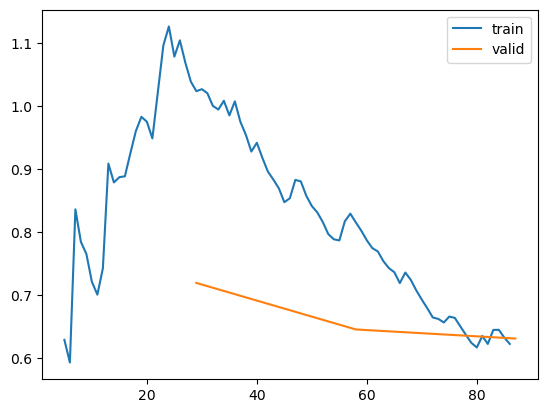

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=100)

,text,start/end,answer,pred start/end,pred answer
0,how many people lost their jobs over beyonce backing out of the deal? the release of a video - game,"(51, 52)",70,"(51, 53)",70 staff
1,"what language does she mainly sing? beyonce's music is generally r & b, but she also incorporates po","(67, 68)",english,"(67, 69)",english songs


In [ ]:
learn.blurr_predict(inf_df.iloc[0])

[(('14', '15'),
  (#2) [tensor(14),tensor(15)],
  (#2) [tensor([1.0657e-07, 5.4776e-08, 8.6471e-09, 5.0581e-09, 4.8368e-09, 1.5612e-08,
        2.3778e-09, 1.0657e-07, 1.6885e-06, 6.5305e-07, 7.0761e-06, 3.5149e-06,
        8.6094e-07, 1.3702e-03, 9.9861e-01, 1.1449e-06, 8.6277e-08, 3.4825e-08,
        4.7763e-09, 2.8264e-08, 6.6089e-08, 5.0073e-08, 1.0609e-07]),tensor([3.3996e-04, 1.7806e-05, 6.7817e-06, 2.9804e-06, 4.8718e-06, 3.4698e-06,
        9.4564e-06, 3.3996e-04, 3.9250e-05, 4.5787e-05, 7.2969e-05, 1.5153e-05,
        5.5251e-05, 1.7372e-04, 1.2726e-03, 9.9478e-01, 2.2510e-03, 3.0527e-05,
        2.8377e-05, 2.1274e-05, 7.4848e-05, 7.3545e-05, 3.3892e-04])])]

In [ ]:
preds, pred_classes, probs = zip(*learn.blurr_predict(inf_df.iloc[0]))
preds

(('14', '15'),)

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0][0]):int(preds[0][1])]

['1977']

### Inference

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
export_name = 'q_and_a_learn_export'

In [ ]:
learn.loss_func = CrossEntropyLossFlat()
learn.export(fname=f'{export_name}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_name}.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {
        'question': 'What did George Lucas make?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
    }, {
        'question': 'What year did Star Wars come out?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }, {
        'question': 'What did George Lucas do?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }], 
    orient='columns')

inf_learn.blurr_predict(inf_df)

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([1.5585e-07, 7.8991e-08, 3.4908e-09, 6.7847e-09, 5.0208e-09, 4.2401e-09,
        5.3373e-10, 1.5586e-07, 2.3979e-04, 2.1980e-05, 2.3050e-03, 9.9726e-01,
        1.5265e-04, 2.3881e-07, 1.2030e-05, 2.7228e-07, 3.4148e-06, 4.1908e-06,
        1.7344e-08, 1.7954e-06, 4.5426e-07, 7.8944e-08, 1.5528e-07, 2.5988e-10,
        3.1127e-10]),tensor([7.7003e-04, 2.6670e-05, 2.6976e-06, 1.1633e-06, 3.3343e-06, 1.4810e-06,
        5.5154e-06, 7.7005e-04, 2.3225e-05, 5.5238e-05, 4.7978e-05, 1.1587e-05,
        2.5748e-02, 6.8899e-01, 9.1303e-03, 2.6246e-01, 1.4202e-04, 4.2222e-05,
        1.2873e-04, 8.1759e-05, 3.4662e-03, 7.3247e-03, 7.6155e-04, 7.1637e-07,
        4.7786e-07])]),
 (('16', '17'),
  (#2) [tensor(16),tensor(17)],
  (#2) [tensor([4.0698e-07, 3.0662e-06, 3.7774e-08, 1.5162e-08, 1.2773e-08, 1.0293e-08,
        1.6093e-08, 1.9580e-08, 8.6332e-09, 4.0701e-07, 3.9063e-07, 5.1024e-07,
        9.3845e-07, 1.8408e-06, 1.0295e-06,

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

## High-level API

### BLearnerForQuestionAnswering

In [ ]:
#hide
try: del learn; del inf_learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#export
@delegates(Blearner.__init__)
class BlearnerForQuestionAnswering(Blearner):

    def __init__(
        self, 
        dls, 
        hf_model, 
        **kwargs
    ):
        kwargs['loss_func'] = kwargs.get('loss_func', MultiTargetLoss())
        super().__init__(dls, hf_model, base_model_cb=HF_QstAndAnsModelCallback, **kwargs)
        
    @classmethod
    def get_model_cls(self): 
        return AutoModelForQuestionAnswering
    
    @classmethod
    def _get_x(
        cls, 
        x, 
        qst, 
        ctx, 
        padding_side='right'
    ): 
         return (x[qst], x[ctx]) if (padding_side == 'right') else (x[ctx], x[qst])
        
    @classmethod
    def _create_learner(
        cls, 
        data, 
        pretrained_model_name_or_path, 
        preprocess_func, 
        max_seq_len,
        context_attr, 
        question_attr, 
        answer_text_attr,
        tok_ans_start_attr, 
        tok_ans_end_attr, 
        dblock_splitter, 
        dl_kwargs, 
        learner_kwargs
    ):
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name_or_path, 
                                                                          model_cls=cls.get_model_cls())
        
        # potentially used by our preprocess_func, it is the basis for our CategoryBlock vocab
        if (max_seq_len is None):
            max_seq_len = hf_config.get('max_position_embeddings', 128)
            
        # client can pass in a function that takes the raw data, hf objects, and max_seq_len ... and
        # returns a DataFrame with the expected format
        if (preprocess_func):
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, max_seq_len, 
                                   context_attr, question_attr, answer_text_attr, 
                                   tok_ans_start_attr, tok_ans_end_attr)
        
        # bits required by our "before_batch_tfm" and DataBlock
        vocab = list(range(max_seq_len))
        padding_side = hf_tokenizer.padding_side
        trunc_strat = 'only_second' if (padding_side == 'right') else 'only_first'

        before_batch_tfm = HF_QABeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                     max_length=max_seq_len, 
                                                     truncation=trunc_strat, 
                                                     tok_kwargs={ 'return_special_tokens_mask': True })
        
        # define getters
        if (isinstance(data, pd.DataFrame)):
            get_x = partial(cls._get_x, qst=question_attr, ctx=context_attr, padding_side=padding_side)
            get_y = [ColReader(tok_ans_start_attr), ColReader(tok_ans_end_attr)]
        else:
            get_x = partial(cls._get_x, qst=question_attr, ctx=context_attr, padding_side=padding_side)
            get_y = [ItemGetter(tok_ans_start_attr), ItemGetter(tok_ans_end_attr)]
            
        # define DataBlock and DataLoaders
        blocks = (
            HF_TextBlock(before_batch_tfm=before_batch_tfm, input_return_type=HF_QuestionAnswerInput), 
            CategoryBlock(vocab=vocab),
            CategoryBlock(vocab=vocab)
        )
        
        dblock = DataBlock(blocks=blocks, 
                           get_x=get_x,
                           get_y=get_y,
                           splitter=dblock_splitter,
                           n_inp=1)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())
        
        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())

    @classmethod
    def from_dataframe(
        cls, 
        df, 
        pretrained_model_name_or_path, 
        preprocess_func=None, 
        max_seq_len=None,
        context_attr='context', 
        question_attr='question', 
        answer_text_attr='answer_text',
        tok_ans_start_attr='tok_answer_start',
        tok_ans_end_attr='tok_answer_end',
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        return cls._create_learner(df, pretrained_model_name_or_path, preprocess_func, max_seq_len,
                                   context_attr, question_attr, answer_text_attr,
                                   tok_ans_start_attr, tok_ans_end_attr, dblock_splitter,
                                   dl_kwargs, learner_kwargs)
    
    @classmethod
    def from_csv(
        cls, 
        csv_file, 
        pretrained_model_name_or_path, 
        preprocess_func=None, 
        max_seq_len=None,
        context_attr='context', 
        question_attr='question', 
        answer_text_attr='answer_text',
        tok_ans_start_attr='tok_answer_start', 
        tok_ans_end_attr='tok_answer_end',
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        df = pd.read_csv(csv_file)
        
        return cls.from_dataframe(df, pretrained_model_name_or_path, preprocess_func, max_seq_len,
                                  context_attr, question_attr, answer_text_attr,
                                  tok_ans_start_attr, tok_ans_end_attr, dblock_splitter,
                                  dl_kwargs, learner_kwargs)
    
    @classmethod
    def from_dictionaries(
        cls, 
        ds, 
        pretrained_model_name_or_path, 
        preprocess_func=None, 
        max_seq_len=None,
        context_attr='context', 
        question_attr='question', 
        answer_text_attr='answer_text',
        tok_ans_start_attr='tok_answer_start', 
        tok_ans_end_attr='tok_answer_end',
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        return cls._create_learner(ds, pretrained_model_name_or_path, preprocess_func, max_seq_len,
                                   context_attr, question_attr, answer_text_attr, 
                                   tok_ans_start_attr, tok_ans_end_attr, dblock_splitter,
                                   dl_kwargs, learner_kwargs)

`BLearnerForQuestionAnswering` requires a question, context (within which to find the answer to the question), and the start/end indices of where the answer lies in the *tokenized context*. Because those indices vary by tokenizer, we can pass a `preprocess_func` that will take our raw data, perform any preprocessing we want, and return it in a way that will work for extractive QA.

In [ ]:
def preprocess_df(df, hf_arch, hf_config, hf_tokenizer, hf_model, max_seq_len, 
                  context_attr, question_attr, answer_text_attr, tok_ans_start_attr, tok_ans_end_attr):
    
    df = df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, ctx_attr=context_attr, 
                          qst_attr=question_attr, ans_attr=answer_text_attr), axis=1)
    
    df = df[(df.tokenized_input_len < max_seq_len) & (df.is_impossible == False)]
    
    return df

Let's re-grab the raw data and use the high-level API to train

In [ ]:
squad_df = pd.read_csv('./squad_sample.csv')

pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'

learn = BlearnerForQuestionAnswering.from_dataframe(squad_df, pretrained_model_name,
                                                    preprocess_func=preprocess_df, max_seq_len=128,
                                                    dblock_splitter=RandomSplitter(), 
                                                    dl_kwargs={ 'bs': 4 }).to_fp16()

In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=500)

,text,start/end,answer
0,"where did beyonce perform in 2011? in 2011, documents obtained by wikileaks revealed that beyonce was one of many entertainers who performed for the family of libyan ruler muammar gaddafi. rolling stone reported that the music industry was urging them to return the money they earned for the concerts ; a spokesperson for beyonce later confirmed to the huffington post that she donated the money to the clinton bush haiti fund. later that year she became the first solo female artist to headline the","(102, 107)",glastonbury festival
1,"what language does she mainly sing? beyonce's music is generally r & b, but she also incorporates pop, soul and funk into her songs. 4 demonstrated beyonce's exploration of 90s - style r & b, as well as further use of soul and hip hop than compared to previous releases. while she almost exclusively releases english songs, beyonce recorded several spanish songs for irreemplazable ( re - recordings of songs from b'day for a spanish - language audience ), and the re - release of b'day. to record th","(67, 68)",english


In [ ]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.309494,2.218958,00:06
1,2.372372,1.658942,00:06
2,1.585692,1.608185,00:06


In [ ]:
learn.show_results(learner=learn, skip_special_tokens=True, max_n=2, trunc_at=500)

,text,start/end,answer,pred start/end,pred answer
0,"how much money did beyonce contribute at the beginning of her hurricane katrina foundation? after hurricane katrina in 2005, beyonce and rowland founded the survivor foundation to provide transitional housing for victims in the houston area, to which beyonce contributed an initial $ 250, 000. the foundation has since expanded to work with other charities in the city, and also provided relief following hurricane ike three years later.","(47, 52)","$ 250, 000.","(48, 51)","250, 000"
1,"which famous landmark did beyonce see in china? beyonce announced a hiatus from her music career in january 2010, heeding her mother's advice, "" to live life, to be inspired by things again "". during the break she and her father parted ways as business partners. beyonce's musical break lasted nine months and saw her visit multiple european cities, the great wall of china, the egyptian pyramids, australia, english music festivals and various museums and ballet performances.","(73, 78)",the great wall of china,"(73, 78)",the great wall of china


In [ ]:
learn.loss_func = CrossEntropyLossFlat()
learn.export(fname=f'{export_name}.pkl')
inf_learn = load_learner(fname=f'{export_name}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_name}.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {
        'question': 'What did George Lucas make?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
    }, {
        'question': 'What year did Star Wars come out?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }, {
        'question': 'What did George Lucas do?',
        'context': 'George Lucas created Star Wars in 1977. He directed and produced it.' 
    }], 
    orient='columns')

inf_learn.blurr_predict(inf_df)

[(('11', '13'),
  (#2) [tensor(11),tensor(13)],
  (#2) [tensor([1.4206e-07, 2.5688e-08, 2.2696e-09, 5.3805e-09, 3.5349e-09, 2.2869e-09,
        3.3779e-10, 1.4205e-07, 3.8560e-04, 1.8396e-05, 8.8490e-04, 9.9857e-01,
        1.2422e-04, 2.4202e-07, 6.8028e-06, 2.6623e-07, 5.9952e-06, 4.3516e-06,
        1.1527e-08, 1.3937e-06, 5.3268e-07, 5.7159e-08, 1.0771e-07, 1.9284e-10,
        2.4141e-10]),tensor([1.8458e-03, 4.2962e-05, 4.2528e-06, 1.5079e-06, 6.7354e-06, 3.6693e-06,
        1.3759e-05, 1.8460e-03, 2.5156e-05, 9.7792e-05, 7.8011e-05, 1.3500e-05,
        5.7974e-02, 4.8361e-01, 3.5420e-02, 3.9014e-01, 1.3801e-04, 5.4505e-05,
        1.1898e-04, 1.5946e-04, 5.8572e-03, 2.0894e-02, 1.6559e-03, 1.1390e-06,
        7.4677e-07])]),
 (('16', '17'),
  (#2) [tensor(16),tensor(17)],
  (#2) [tensor([4.9172e-07, 1.6086e-06, 2.4050e-08, 1.4412e-08, 1.2125e-08, 8.4776e-09,
        1.3886e-08, 1.6740e-08, 6.4203e-09, 4.9176e-07, 5.5858e-07, 6.4657e-07,
        9.5389e-07, 2.6076e-06, 9.5531e-07,

## Summary

This module includes all the low, mid, and high-level API bits for extractive Q&A tasks training and inference.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted index.ipynb.
